# Import library

In [4]:
import os
import os, sys
import glob
import re
import datetime
from datetime import datetime, timedelta 
import math, copy, time
from itertools import cycle
from collections import defaultdict

from parse import parse
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import svm


from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
pd.set_option("display.max_column", 100)

In [6]:
# Util functions
def size_and_ratio(df, col, dropna=True):
    if pd.__version__ > '1.1':
        sr = df.groupby(col, dropna=dropna).size().sort_values(ascending=False)
    elif dropna:
        sr = df.groupby(col).size().sort_values(ascending=False)
    else:  # dropna == False
        sr = df.fillna('nan').groupby(col).size().sort_values(ascending=False)
    sr_ratio = sr.copy() / sum(sr)
    print("Sum :", sum(sr), sr.shape)
    sr.name = 'size'
    sr_ratio.name = 'ratio'
    return pd.concat([sr, sr_ratio], axis=1)

# Data load

In [17]:
df_all.columns.tolist()

['baby_id',
 'self_check_date',
 'cough',
 'fever',
 'sore_throat',
 'shortness_of_breath',
 'head_ache',
 'runny_nose',
 'muscle_pain',
 'chills',
 'loss_of_taste',
 'loss_of_smell',
 'sputum',
 'chest_pain',
 'indication_other',
 'indication_abroad',
 'indication_contact',
 'global_confirmed_ratio',
 'confirmed_ratio',
 'sigungu_confirmed_ratio',
 'mask',
 'gender',
 'age_ratio',
 'weekday',
 'pcr_result',
 'split',
 'iso_code',
 'date',
 'total_cases_per_million_norm',
 'total_cases_per_million_mask',
 'new_cases_per_million_norm',
 'new_cases_per_million_mask',
 'new_cases_smoothed_per_million_norm',
 'new_cases_smoothed_per_million_mask',
 'total_deaths_per_million_norm',
 'total_deaths_per_million_mask',
 'new_deaths_per_million_norm',
 'new_deaths_per_million_mask',
 'new_deaths_smoothed_per_million_norm',
 'new_deaths_smoothed_per_million_mask',
 'icu_patients_per_million_norm',
 'icu_patients_per_million_mask',
 'hosp_patients_per_million_norm',
 'hosp_patients_per_million_mas

In [88]:
df_all = pd.read_csv("data/df_data_v3_1/df_all_v3_12_added_owid.csv")

df_train1 = df_all[df_all['split'] == 'TRAIN']
df_val1 = df_all[df_all['split'] == 'VALIDATE']
df_test1 = df_all[df_all['split'] == 'TEST']
print(df_train1.shape, df_val1.shape, df_test1.shape)
df_train1.head()

(13961, 70) (4750, 70) (4615, 70)


,baby_id,self_check_date,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,pcr_result,split,iso_code,date,total_cases_per_million_norm,total_cases_per_million_mask,new_cases_per_million_norm,new_cases_per_million_mask,new_cases_smoothed_per_million_norm,new_cases_smoothed_per_million_mask,total_deaths_per_million_norm,total_deaths_per_million_mask,new_deaths_per_million_norm,new_deaths_per_million_mask,new_deaths_smoothed_per_million_norm,new_deaths_smoothed_per_million_mask,icu_patients_per_million_norm,icu_patients_per_million_mask,hosp_patients_per_million_norm,hosp_patients_per_million_mask,weekly_icu_admissions_per_million_norm,weekly_icu_admissions_per_million_mask,weekly_hosp_admissions_per_million_norm,weekly_hosp_admissions_per_million_mask,total_tests_per_thousand_norm,total_tests_per_thousand_mask,new_tests_per_thousand_norm,new_tests_per_thousand_mask,new_tests_smoothed_per_thousand_norm,new_tests_smoothed_per_thousand_mask,total_vaccinations_per_hundred_norm,total_vaccinations_per_hundred_mask,people_vaccinated_per_hundred_norm,people_vaccinated_per_hundred_mask,people_fully_vaccinated_per_hundred_norm,people_fully_vaccinated_per_hundred_mask,total_boosters_per_hundred_norm,total_boosters_per_hundred_mask,new_vaccinations_smoothed_per_million_norm,new_vaccinations_smoothed_per_million_mask,new_people_vaccinated_smoothed_per_hundred_norm,new_people_vaccinated_smoothed_per_hundred_mask,hospital_beds_per_thousand_norm,hospital_beds_per_thousand_mask,excess_mortality_cumulative_per_million_norm,excess_mortality_cumulative_per_million_mask
0,21165,2021-12-08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.178983,0.008614,0.013530,1,1.0,0.39,4,0,TRAIN,KOR,2021-12-08,0.014128,0.0,0.000605,0.0,0.002749,0.0,0.012177,0.0,0.002014,0.0,0.006714,0.0,0.089725,0.0,0.0,1.0,0.000000,1.0,0.142005,0.0,0.023348,0.0,0.009942,0.0,0.029918,0.0,0.449554,0.0,0.639251,0.0,0.629931,0.0,0.067609,0.0,0.048295,0.0,0.005123,0.0,0.88913,0.0,0.0,1.0
1,21151,2021-12-07,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0.178983,0.008614,0.013084,1,0.0,0.18,4,0,TRAIN,KOR,2021-12-07,0.013921,0.0,0.000418,0.0,0.002597,0.0,0.011986,0.0,0.002046,0.0,0.006176,0.0,0.082679,0.0,0.0,1.0,0.000000,1.0,0.135609,0.0,0.023187,0.0,0.009942,0.0,0.028753,0.0,0.447462,0.0,0.638552,0.0,0.629142,0.0,0.063375,0.0,0.044743,0.0,0.004611,0.0,0.88913,0.0,0.0,1.0
2,21110,2021-12-04,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.178983,0.008614,0.000000,0,0.0,0.36,4,0,TRAIN,KOR,2021-12-04,0.013505,0.0,0.000451,0.0,0.002290,0.0,0.011538,0.0,0.002238,0.0,0.005880,0.0,0.080327,0.0,0.0,1.0,0.045891,0.0,0.128912,0.0,0.022831,0.0,0.009532,0.0,0.026524,0.0,0.443412,0.0,0.637154,0.0,0.627406,0.0,0.055193,0.0,0.039919,0.0,0.003672,0.0,0.88913,0.0,0.0,1.0
3,21240,2021-12-14,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.115645,0.008252,0.013246,1,1.0,0.42,5,0,TRAIN,KOR,2021-12-14,0.015258,0.0,0.000469,0.0,0.003430,0.0,0.013288,0.0,0.003005,0.0,0.007979,0.0,0.096776,0.0,0.0,1.0,0.000000,1.0,0.156465,0.0,0.024230,0.0,0.010381,0.0,0.033217,0.0,0.468192,0.0,0.643135,0.0,0.634112,0.0,0.110744,0.0,0.095421,0.0,0.007173,0.0,0.88913,0.0,0.0,1.0
4,21162,2021-12-08,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.172342,0.007970,0.013421,1,0.0,0.36,0,0,TRAIN,KOR,2021-12-08,0.014128,0.0,0.000605,0.0,0.002749,0.0,0.012177,0.0,0.002014,0.0,0.006714,0.0,0.089725,0.0,0.0,1.0,0.000000,1.0,0.142005,0.0,0.023348,0.0,0.009942,0.0,0.029918,0.0,0.449554,0.0,0.639251,0.0,0.629931,0.0,0.067609,0.0,0.048295,0.0,0.005123,0.0,0.88913,0.0,0.0,1.0


In [21]:
df_all = pd.read_csv("data/df_data_v3_1/df_all_v3_12_added_owid.csv")
base_columns = ['baby_id',
 'cough',
 'fever',
 'sore_throat',
 'shortness_of_breath',
 'head_ache',
 'runny_nose',
 'muscle_pain',
 'chills',
 'loss_of_taste',
 'loss_of_smell',
 'sputum',
 'chest_pain',
 'indication_other',
 'indication_abroad',
 'indication_contact',
 'gender',
 'age_ratio',
 'weekday',
 'pcr_result', 'split']

df_all = df_all[base_columns].copy()
print("Null:", df_all.isnull().sum().sum())

df_train = df_all[df_all['split'] == 'TRAIN']
df_val = df_all[df_all['split'] == 'VALIDATE']
df_test = df_all[df_all['split'] == 'TEST']
print(df_train.shape, df_val.shape, df_test.shape)
df_train.head()

Null: 0
(13961, 21) (4750, 21) (4615, 21)


,baby_id,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,gender,age_ratio,weekday,pcr_result,split
0,21165,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.0,0.39,4,0,TRAIN
1,21151,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0.0,0.18,4,0,TRAIN
2,21110,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.36,4,0,TRAIN
3,21240,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.0,0.42,5,0,TRAIN
4,21162,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.36,0,0,TRAIN


In [22]:
import random
print("Train:", df_train.shape, df_train['baby_id'].nunique())
print("Validaiton:", df_val.shape, df_val['baby_id'].nunique())

Train: (13961, 21) 9641
Validaiton: (4750, 21) 3213


## Remove baby_id and results

In [34]:
exclude_cols = ['baby_id', 'pcr_result', 'split']
cols = [x for x in df_train.columns if x not in exclude_cols]

df_train_gt = df_train[['pcr_result']]
df_train_input = df_train[cols]
df_val_gt = df_val[['pcr_result']]
df_val_input = df_val[cols]
df_test_gt = df_test[['pcr_result']]
df_test_input = df_test[cols]


In [35]:
df_trainval = pd.concat([df_train, df_val], axis=0)
print(df_trainval.shape)


(18711, 21)


In [36]:
size_and_ratio(df_trainval, 'pcr_result')

Sum : 18711 (2,)


,size,ratio
pcr_result,,
1,13526,0.72289
0,5185,0.27711


In [37]:
size_and_ratio(df_test, 'pcr_result')

Sum : 4615 (2,)


,size,ratio
pcr_result,,
1,3284,0.711593
0,1331,0.288407


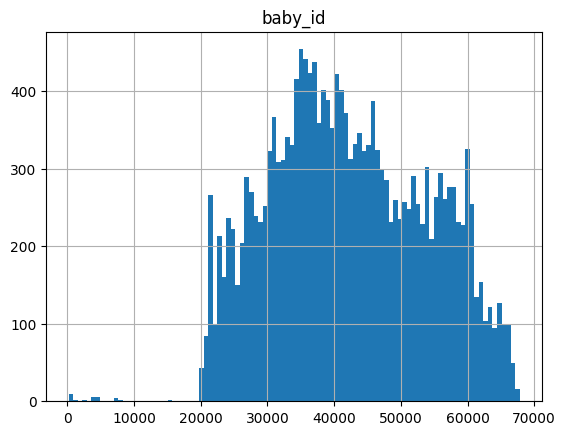

In [38]:
df_trainval.hist('baby_id', bins=100)
plt.show()

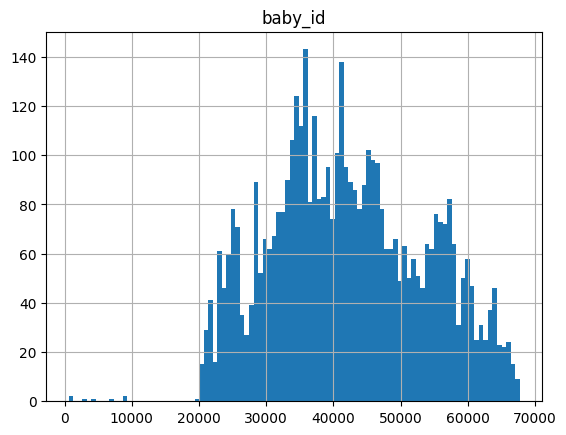

In [39]:
df_test.hist('baby_id',bins=100)
plt.show()

In [40]:
print(df_trainval['baby_id'].nunique(), df_test['baby_id'].nunique())

12854 3214


# Check Logistic regression performance

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def run_one_full_train_test(df_trainval, df_test, cols, model):
    x = df_trainval[cols]
    y = df_trainval['pcr_result']
    print(f"start to train: x.shape:{x.shape}, y.shape:{y.shape}")

    model.fit(x, y)
    print(f"Model: {model}")
    if getattr(model, 'predict_proba', False):
        print("Found predict_proba")
        pred_raw = model.predict_proba(df_trainval[cols])
        pred_pos = np.array([x[1] for x in pred_raw])
    else:
        pred_pos = model.predict(df_trainval[cols])
    
    gt = df_trainval['pcr_result']

    print(pred_pos.shape, gt.shape)
    print("train set auc", roc_auc_score(gt, pred_pos))

    if getattr(model, 'predict_proba', False):
        pred_raw = model.predict_proba(df_test[cols])
        pred_pos = np.array([x[1] for x in pred_raw])
    else:
        pred_pos = model.predict(df_test[cols])
    
    gt = df_test['pcr_result']
    test_result = roc_auc_score(gt, pred_pos)
    print("test set auc", test_result)
        
    return model, test_result

lr_model = LogisticRegression()

run_one_full_train_test(df_trainval, df_test, cols, lr_model)

start to train: x.shape:(18711, 18), y.shape:(18711,)
Model: LogisticRegression()
Found predict_proba
(18711,) (18711,)
train set auc 0.820287817412545
test set auc 0.8071193712016735


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(LogisticRegression(), 0.8071193712016735)

## repeat 5 times

In [80]:
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        lr_model
    )

start to train: x.shape:(14968, 18), y.shape:(14968,)
Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.8211364771890627
test set auc 0.8071239468094744
start to train: x.shape:(14968, 18), y.shape:(14968,)


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.821066158836742
test set auc 0.8070015493008015
start to train: x.shape:(14968, 18), y.shape:(14968,)
Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.8203351507879132
test set auc 0.8077414250822008
start to train: x.shape:(14968, 18), y.shape:(14968,)


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.8208195847462206
test set auc 0.807015276124204
start to train: x.shape:(14968, 18), y.shape:(14968,)
Model: LogisticRegression()
Found predict_proba
(14968,) (14968,)
train set auc 0.8196805402795431
test set auc 0.807164212158122


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
# final_result = dict()

In [82]:


test_result['mean'] = np.mean(list(test_result.values()))
test_result['std'] = np.std(list(test_result.values()))
print(test_result)

final_result['LR'] = test_result


{0: 0.8071239468094744, 1: 0.8070015493008015, 2: 0.8077414250822008, 3: 0.807015276124204, 4: 0.807164212158122, 'mean': 0.8072092818949607, 'std': 0.0002494262748398013}


### Use xgboost

In [61]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [62]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [63]:

run_one_full_train_test(df_trainval, df_test, cols, xg_reg)

start to train: x.shape:(18711, 18), y.shape:(18711,)
[23:02:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', ...)
(18711,) (18711,)
train set 

(XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='reg:linear', ...),
 0.7984171371154087)

In [64]:
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        xg_reg
    )

start to train: x.shape:(14968, 18), y.shape:(14968,)
[23:02:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', ...)
(14968,) (14968,)
train set 

In [65]:


test_result['mean'] = np.mean(list(test_result.values()))
test_result['std'] = np.std(list(test_result.values()))
print(test_result)

final_result['XGBoost'] = test_result


{0: 0.7982440647503412, 1: 0.7981707406353323, 2: 0.7957998894533155, 3: 0.7981519806433487, 4: 0.7981733716098177, 'mean': 0.7977080094184311, 'std': 0.0008714040124002865}


### LGBM

In [66]:
import lightgbm as lgb

In [67]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        lgb_model
    )

start to train: x.shape:(14968, 18), y.shape:(14968,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14968,) (14968,)
train set auc 0.8696492568231394
test set auc 0.8162310077959204
start to train: x.shape:(14968, 18), y.shape:(14968,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14968,) (14968,)
train set auc 0.871311088798822
test set auc 0.8142461091319065
start to train: x.shape:(14968, 18), y.shape:(14968,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14968,) (14968,)
train set auc 0.8690171097166831
test set auc 0.8174297026495516
start to train: x.shape:(14968, 18), y.shape:(14968,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(14968,) (14968,)
train set auc 0.8714829818849533
test set auc 0.8153123401397024
start to train: x.shape:(14968, 18), y.shape:(14968,)
Model: LGBMClassifier(learn

In [68]:


test_result['mean'] = np.mean(list(test_result.values()))
test_result['std'] = np.std(list(test_result.values()))
print(test_result)

final_result['LGBM'] = test_result


{0: 0.8162310077959204, 1: 0.8142461091319065, 2: 0.8174297026495516, 3: 0.8153123401397024, 4: 0.8151304597296183, 'mean': 0.8156699238893399, 'std': 0.0009880766346991065}


## TabNet

In [69]:
import pandas as pd
import numpy  as np
from tqdm.auto import tqdm
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import torch

start to train: x_train.shape:(14968, 18), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 18), y_val.shape:(3743,)
y_train mean:0.7238107963655799. y_val mean:0.7192091904889126


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56089 | train_auc: 0.76164 | valid_auc: 0.75271 |  0:00:01s
epoch 2  | loss: 0.46495 | train_auc: 0.79772 | valid_auc: 0.79883 |  0:00:04s
epoch 4  | loss: 0.45631 | train_auc: 0.80483 | valid_auc: 0.8094  |  0:00:07s
epoch 6  | loss: 0.45408 | train_auc: 0.80497 | valid_auc: 0.80785 |  0:00:10s
epoch 8  | loss: 0.45265 | train_auc: 0.81151 | valid_auc: 0.81684 |  0:00:13s
epoch 10 | loss: 0.45174 | train_auc: 0.81    | valid_auc: 0.81281 |  0:00:16s
epoch 12 | loss: 0.45182 | train_auc: 0.81639 | valid_auc: 0.82213 |  0:00:19s
epoch 14 | loss: 0.44848 | train_auc: 0.81683 | valid_auc: 0.82284 |  0:00:22s
epoch 16 | loss: 0.44907 | train_auc: 0.81944 | valid_auc: 0.82553 |  0:00:25s
epoch 18 | loss: 0.44709 | train_auc: 0.82061 | valid_auc: 0.82504 |  0:00:28s
epoch 20 | loss: 0.44692 | train_auc: 0.82068 | valid_auc: 0.82406 |  0:00:31s
epoch 22 | loss: 0.4444  | train_auc: 0.82205 | valid_auc: 0.82483 |  0:00:34s
epoch 24 | loss: 0.44671 | train_auc: 0.82306 | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=18, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


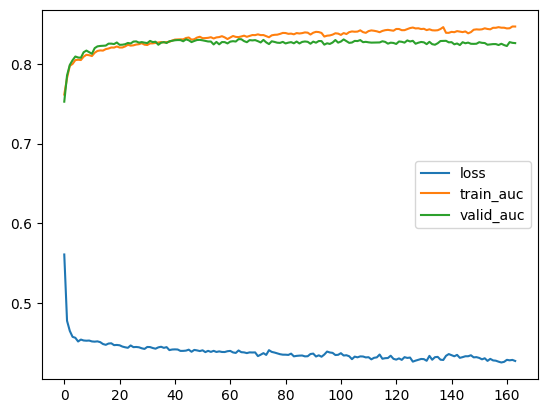

y_val.head:[1 1 1 0 1]
BEST AUC SCORE ON VALIDATION SET : 0.831180733554543
start to test: x_test.shape:(4615, 18), y_test.shape:(4615,)


array([0.02754183, 0.15281703, 0.13174566, 0.01503957, 0.00529066,
       0.11041677, 0.01286182, 0.08087522, 0.03979114, 0.06550434,
       0.1541385 , 0.00240339, 0.01238073, 0.01868575, 0.00591843,
       0.02655645, 0.12883818, 0.00919452])

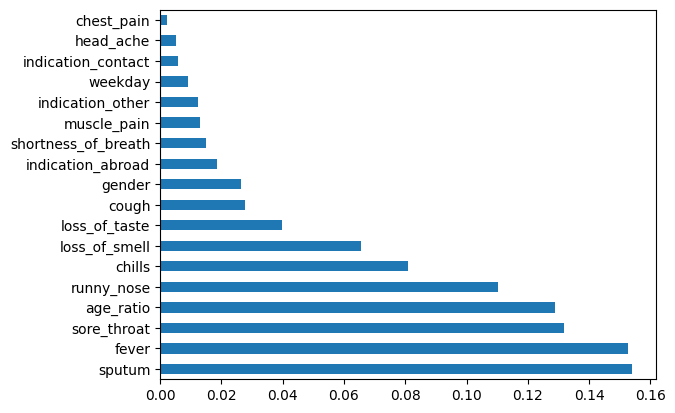

preds_test head:[[0.5482692  0.45173073]
 [0.60940987 0.39059013]
 [0.5708778  0.42912224]
 [0.3363392  0.66366076]
 [0.2566442  0.7433558 ]]
BEST AUC SCORE ON TEST SET : 0.8118673650264333
Best epoch:63
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0063.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0063.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0063.pth
start to train: x_train.shape:(14968, 18), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 18), y_val.shape:(3743,)
y_train mean:0.7222741849278461. y_val mean:0.7253539941223618


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56222 | train_auc: 0.75777 | valid_auc: 0.76231 |  0:00:01s
epoch 2  | loss: 0.46763 | train_auc: 0.78076 | valid_auc: 0.78207 |  0:00:04s
epoch 4  | loss: 0.45891 | train_auc: 0.79576 | valid_auc: 0.80072 |  0:00:07s
epoch 6  | loss: 0.45773 | train_auc: 0.79906 | valid_auc: 0.80119 |  0:00:10s
epoch 8  | loss: 0.45122 | train_auc: 0.8033  | valid_auc: 0.80826 |  0:00:13s
epoch 10 | loss: 0.45339 | train_auc: 0.80571 | valid_auc: 0.80623 |  0:00:16s
epoch 12 | loss: 0.452   | train_auc: 0.80986 | valid_auc: 0.80949 |  0:00:19s
epoch 14 | loss: 0.44841 | train_auc: 0.81407 | valid_auc: 0.81306 |  0:00:22s
epoch 16 | loss: 0.44754 | train_auc: 0.81665 | valid_auc: 0.81818 |  0:00:25s
epoch 18 | loss: 0.44683 | train_auc: 0.81727 | valid_auc: 0.81831 |  0:00:27s
epoch 20 | loss: 0.44745 | train_auc: 0.82171 | valid_auc: 0.8204  |  0:00:30s
epoch 22 | loss: 0.44504 | train_auc: 0.82184 | valid_auc: 0.821   |  0:00:33s
epoch 24 | loss: 0.44655 | train_auc: 0.82268 | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=18, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


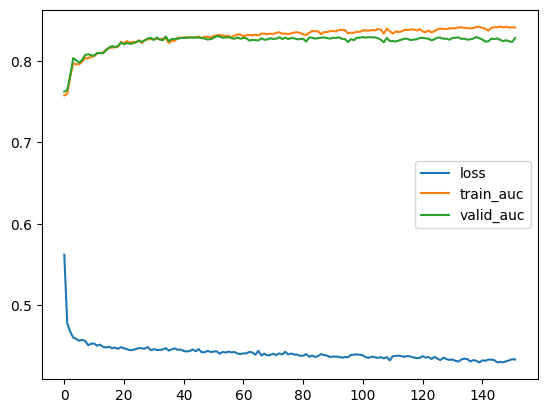

y_val.head:[1 1 1 1 1]
BEST AUC SCORE ON VALIDATION SET : 0.8303449993192453
start to test: x_test.shape:(4615, 18), y_test.shape:(4615,)


array([1.84353455e-01, 8.47694411e-02, 2.47233803e-01, 2.65501592e-02,
       3.66053837e-02, 3.74339606e-02, 2.01582983e-02, 2.33862271e-02,
       1.99963280e-02, 2.05670621e-02, 9.55038096e-02, 1.46931656e-02,
       2.24164810e-02, 6.13684083e-06, 3.95649373e-02, 7.92529770e-02,
       1.75177191e-05, 4.74908566e-02])

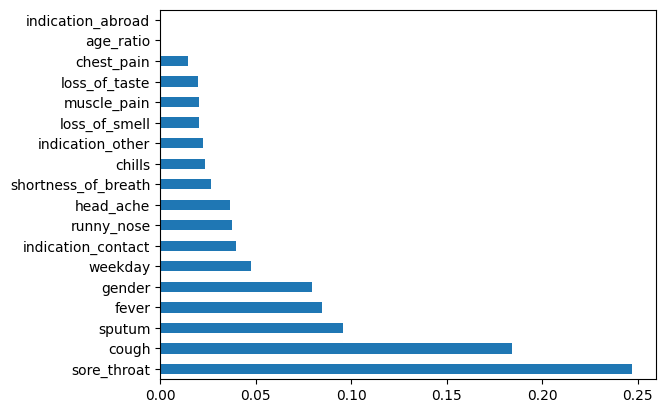

preds_test head:[[0.39926523 0.6007348 ]
 [0.518429   0.48157096]
 [0.48901293 0.51098704]
 [0.28043383 0.7195662 ]
 [0.26521933 0.73478067]]
BEST AUC SCORE ON TEST SET : 0.8089541899298193
Best epoch:51
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0051.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0051.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0051.pth
start to train: x_train.shape:(14968, 18), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 18), y_val.shape:(3743,)
y_train mean:0.7218065205772314. y_val mean:0.7272241517499332


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55979 | train_auc: 0.76514 | valid_auc: 0.76053 |  0:00:01s
epoch 2  | loss: 0.46449 | train_auc: 0.78459 | valid_auc: 0.78546 |  0:00:04s
epoch 4  | loss: 0.45753 | train_auc: 0.7992  | valid_auc: 0.79785 |  0:00:07s
epoch 6  | loss: 0.45819 | train_auc: 0.80388 | valid_auc: 0.80443 |  0:00:10s
epoch 8  | loss: 0.45302 | train_auc: 0.8048  | valid_auc: 0.8045  |  0:00:13s
epoch 10 | loss: 0.45123 | train_auc: 0.81401 | valid_auc: 0.81189 |  0:00:16s
epoch 12 | loss: 0.45075 | train_auc: 0.81684 | valid_auc: 0.81431 |  0:00:19s
epoch 14 | loss: 0.44898 | train_auc: 0.81834 | valid_auc: 0.81707 |  0:00:22s
epoch 16 | loss: 0.44819 | train_auc: 0.8212  | valid_auc: 0.82006 |  0:00:24s
epoch 18 | loss: 0.44659 | train_auc: 0.82018 | valid_auc: 0.81487 |  0:00:27s
epoch 20 | loss: 0.44656 | train_auc: 0.82171 | valid_auc: 0.81917 |  0:00:30s
epoch 22 | loss: 0.44547 | train_auc: 0.82485 | valid_auc: 0.81933 |  0:00:33s
epoch 24 | loss: 0.44673 | train_auc: 0.81945 | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=18, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


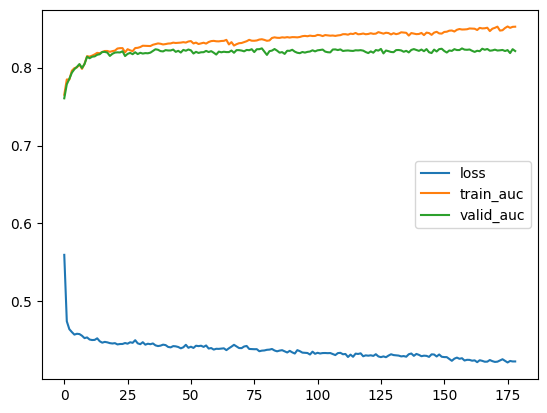

y_val.head:[0 0 0 0 0]
BEST AUC SCORE ON VALIDATION SET : 0.8245929888218103
start to test: x_test.shape:(4615, 18), y_test.shape:(4615,)


array([4.57538616e-02, 8.54254808e-03, 2.34097563e-01, 4.50372365e-03,
       7.45065062e-02, 3.20471783e-02, 8.28389429e-02, 3.67818334e-02,
       5.66574908e-02, 1.92678598e-02, 2.66261087e-01, 0.00000000e+00,
       1.93539448e-05, 1.08420867e-01, 1.58926446e-02, 1.87875923e-04,
       0.00000000e+00, 1.42206639e-02])

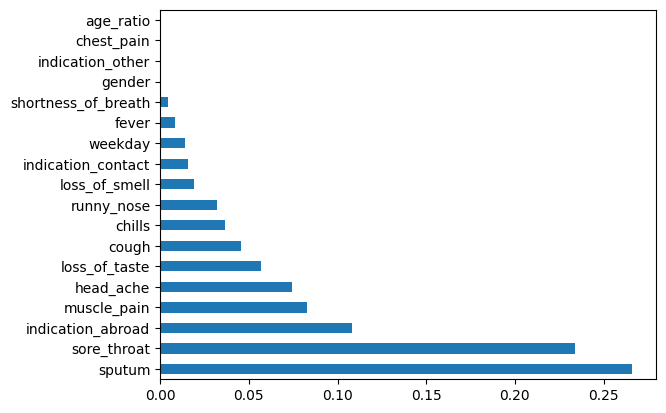

preds_test head:[[0.32832485 0.6716752 ]
 [0.5958003  0.40419978]
 [0.5145019  0.4854981 ]
 [0.4030629  0.59693706]
 [0.1930911  0.8069089 ]]
BEST AUC SCORE ON TEST SET : 0.8114061437601064
Best epoch:78
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0078.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0078.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0078.pth
start to train: x_train.shape:(14968, 18), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 18), y_val.shape:(3743,)
y_train mean:0.7202030999465526. y_val mean:0.7336361207587496


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56047 | train_auc: 0.78679 | valid_auc: 0.79686 |  0:00:01s
epoch 2  | loss: 0.46974 | train_auc: 0.77026 | valid_auc: 0.78072 |  0:00:04s
epoch 4  | loss: 0.46107 | train_auc: 0.7947  | valid_auc: 0.81042 |  0:00:07s
epoch 6  | loss: 0.4568  | train_auc: 0.80513 | valid_auc: 0.82101 |  0:00:10s
epoch 8  | loss: 0.45405 | train_auc: 0.80566 | valid_auc: 0.81767 |  0:00:13s
epoch 10 | loss: 0.45232 | train_auc: 0.80804 | valid_auc: 0.8189  |  0:00:16s
epoch 12 | loss: 0.4515  | train_auc: 0.80703 | valid_auc: 0.81834 |  0:00:18s
epoch 14 | loss: 0.45182 | train_auc: 0.81059 | valid_auc: 0.8178  |  0:00:21s
epoch 16 | loss: 0.45137 | train_auc: 0.81381 | valid_auc: 0.82372 |  0:00:24s
epoch 18 | loss: 0.44831 | train_auc: 0.81918 | valid_auc: 0.8326  |  0:00:26s
epoch 20 | loss: 0.44946 | train_auc: 0.81935 | valid_auc: 0.82589 |  0:00:29s
epoch 22 | loss: 0.44863 | train_auc: 0.82148 | valid_auc: 0.82517 |  0:00:32s
epoch 24 | loss: 0.44721 | train_auc: 0.82177 | vali

epoch 208| loss: 0.4211  | train_auc: 0.85338 | valid_auc: 0.83154 |  0:05:04s
epoch 210| loss: 0.42242 | train_auc: 0.85477 | valid_auc: 0.83157 |  0:05:07s
epoch 212| loss: 0.42123 | train_auc: 0.85485 | valid_auc: 0.83094 |  0:05:10s
epoch 214| loss: 0.42257 | train_auc: 0.85373 | valid_auc: 0.82899 |  0:05:13s
epoch 216| loss: 0.42209 | train_auc: 0.8556  | valid_auc: 0.83177 |  0:05:16s
epoch 218| loss: 0.41968 | train_auc: 0.85463 | valid_auc: 0.83165 |  0:05:19s
epoch 220| loss: 0.41933 | train_auc: 0.85617 | valid_auc: 0.83289 |  0:05:21s
epoch 222| loss: 0.42025 | train_auc: 0.85396 | valid_auc: 0.83256 |  0:05:24s
epoch 224| loss: 0.422   | train_auc: 0.85429 | valid_auc: 0.83077 |  0:05:27s
epoch 226| loss: 0.41962 | train_auc: 0.85634 | valid_auc: 0.83218 |  0:05:30s
epoch 228| loss: 0.42334 | train_auc: 0.8542  | valid_auc: 0.82798 |  0:05:33s
epoch 230| loss: 0.41783 | train_auc: 0.8572  | valid_auc: 0.83246 |  0:05:36s
epoch 232| loss: 0.42022 | train_auc: 0.8574  | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=18, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


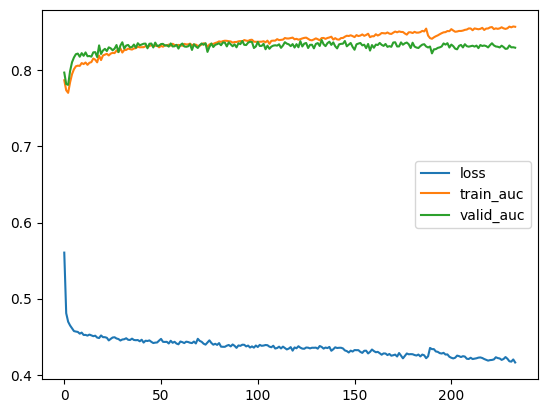

y_val.head:[1 1 1 1 1]
BEST AUC SCORE ON VALIDATION SET : 0.8396403704923949
start to test: x_test.shape:(4615, 18), y_test.shape:(4615,)


array([1.16447553e-01, 1.27680427e-04, 2.30858140e-01, 6.00694035e-02,
       4.39828152e-02, 8.67928714e-02, 3.68691269e-02, 4.99570649e-02,
       4.66786267e-02, 3.88798357e-02, 1.61661478e-01, 1.19886926e-02,
       2.54608507e-02, 2.84366658e-02, 3.87883643e-03, 1.13117796e-03,
       4.57230790e-02, 1.10561023e-02])

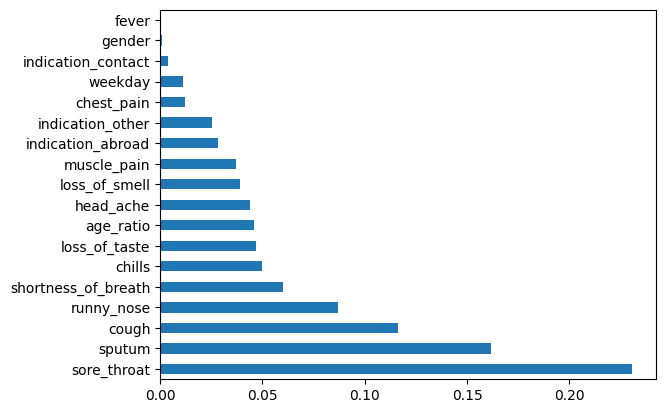

preds_test head:[[0.35578963 0.64421046]
 [0.5948131  0.4051868 ]
 [0.38457885 0.6154211 ]
 [0.3411093  0.65889066]
 [0.21352531 0.78647465]]
BEST AUC SCORE ON TEST SET : 0.8124628803817154
Best epoch:133
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0133.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0133.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0133.pth
start to train: x_train.shape:(14968, 18), y_train.shape:(14968,)
start to train: x_val.shape:(3743, 18), y_val.shape:(3743,)
y_train mean:0.7216729021913415. y_val mean:0.7277584825006679


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57931 | train_auc: 0.6364  | valid_auc: 0.61978 |  0:00:01s
epoch 2  | loss: 0.47853 | train_auc: 0.72243 | valid_auc: 0.70854 |  0:00:04s
epoch 4  | loss: 0.47409 | train_auc: 0.78073 | valid_auc: 0.76053 |  0:00:07s
epoch 6  | loss: 0.46362 | train_auc: 0.79677 | valid_auc: 0.78548 |  0:00:10s
epoch 8  | loss: 0.45895 | train_auc: 0.80345 | valid_auc: 0.79643 |  0:00:13s
epoch 10 | loss: 0.45253 | train_auc: 0.80519 | valid_auc: 0.79855 |  0:00:16s
epoch 12 | loss: 0.45266 | train_auc: 0.81139 | valid_auc: 0.80579 |  0:00:19s
epoch 14 | loss: 0.45269 | train_auc: 0.81426 | valid_auc: 0.80679 |  0:00:22s
epoch 16 | loss: 0.44648 | train_auc: 0.81863 | valid_auc: 0.80955 |  0:00:25s
epoch 18 | loss: 0.44513 | train_auc: 0.81767 | valid_auc: 0.80974 |  0:00:27s
epoch 20 | loss: 0.44776 | train_auc: 0.82362 | valid_auc: 0.81465 |  0:00:30s
epoch 22 | loss: 0.44673 | train_auc: 0.82241 | valid_auc: 0.81239 |  0:00:33s
epoch 24 | loss: 0.44468 | train_auc: 0.82735 | vali

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1212, clip_value=1, verbose=2, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=18, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


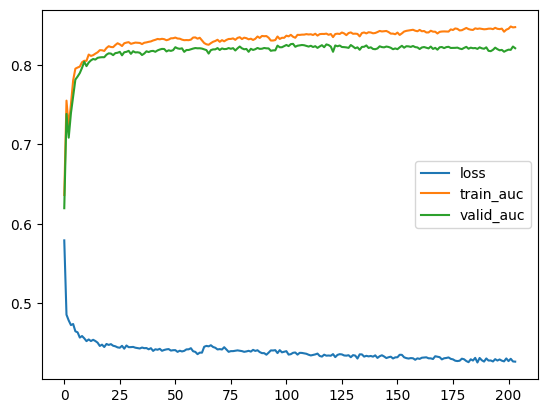

y_val.head:[1 1 0 0 1]
BEST AUC SCORE ON VALIDATION SET : 0.8265849015547477
start to test: x_test.shape:(4615, 18), y_test.shape:(4615,)


array([1.03205218e-01, 1.06389096e-01, 1.90218628e-01, 1.04132353e-02,
       4.67093258e-02, 4.43383195e-04, 9.44433645e-02, 3.81943728e-02,
       3.27063746e-03, 5.87865141e-06, 2.08608569e-01, 1.91974415e-05,
       1.09567165e-02, 4.01923510e-03, 6.07358795e-02, 4.14098786e-02,
       5.70596326e-02, 2.38977511e-02])

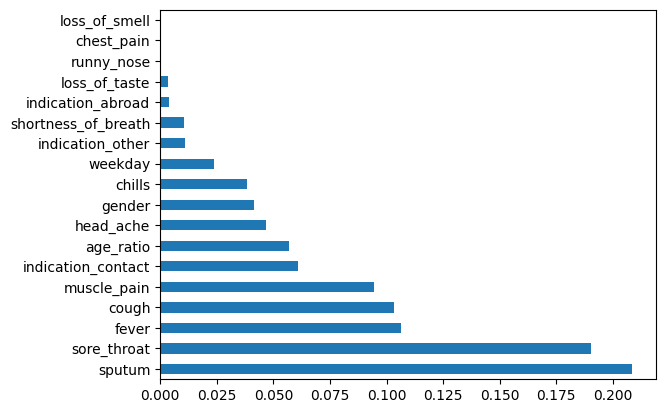

preds_test head:[[0.20651536 0.79348457]
 [0.46960127 0.5303987 ]
 [0.3782834  0.62171656]
 [0.39109018 0.6089099 ]
 [0.15259524 0.8474048 ]]
BEST AUC SCORE ON TEST SET : 0.8107684184228612
Best epoch:103
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0103.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0103.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0103.pth


<Figure size 640x480 with 0 Axes>

In [70]:
def run_one_full_train_test_with_tabnet(df_trainval, df_test, cols, model):
    df_train, df_val = train_test_split(df_trainval, test_size=0.2)
    x_train = df_train[cols].to_numpy()
    y_train = df_train['pcr_result'].to_numpy()
    x_val = df_val[cols].to_numpy()
    y_val = df_val['pcr_result'].to_numpy()
    x_test = df_test[cols].to_numpy()
    y_test = df_test['pcr_result'].to_numpy()

    print(f"start to train: x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}")
    print(f"start to train: x_val.shape:{x_val.shape}, y_val.shape:{y_val.shape}")
    print(f"y_train mean:{np.mean(y_train)}. y_val mean:{np.mean(y_val)}")

    model.fit(
        X_train=x_train, y_train=y_train,
        eval_set=[(x_train, y_train), (x_val, y_val)],
        eval_name=['train', 'valid'],
#         patience=2, 
#         max_epochs=100,
        patience=100, 
        max_epochs=1000,
        eval_metric=['auc'],
    )
    
    print(f"Model: {model}")
    # plot losses
    plt.plot(model.history['loss'], label='loss')

    # plot accuracy
    plt.plot(model.history['train_auc'], label='train_auc')
    plt.plot(model.history['valid_auc'], label='valid_auc')
    plt.legend(['loss', 'train_auc', 'valid_auc'])
    plt.show()
    plt.clf()

    # determine best accuracy for validation set
    preds_valid = model.predict_proba(x_val)
    print(f"y_val.head:{y_val[:5]}")
    pred_pos = np.array([x[1] for x in preds_valid])
    valid_auc = roc_auc_score(y_val, pred_pos)
    print(f"BEST AUC SCORE ON VALIDATION SET : {valid_auc}")
    
    print(f"start to test: x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}")
    # find and plot feature importance
    y_pred = model.predict(x_test)
    feature_importances_ = model.feature_importances_
    display(feature_importances_)
    feat_importances = pd.Series(model.feature_importances_, index=cols)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()
    plt.clf()

    # determine best accuracy for test set
    preds = model.predict_proba(x_test)
    pred_pos = np.array([x[1] for x in preds])
    test_auc = roc_auc_score(y_test, pred_pos)
    print(f"preds_test head:{preds[:5]}")
    print(f"BEST AUC SCORE ON TEST SET : {test_auc}")
    
    config_name = 'TabNet_DEFAULT'
    best_epoch, element = max(enumerate(model.history['valid_auc']), key=lambda x: x[1])
    print(f"Best epoch:{best_epoch}")
    best_model = save_model(config_name, model, best_epoch)
    
    return model, test_auc

def save_model(config_name, model, epoch):
    save_path = f"./train_data/{model.__class__.__name__}_{config_name}_{epoch:04d}.pth"
    print("save_path", save_path)
    model.save_model(save_path)
    print("Success to save to : ", save_path)
    return model


test_result = dict()
models = dict()
for i in range(5):
    tab_model = TabNetClassifier(verbose = 2,seed = 1212)
    models[i], test_result[i] = run_one_full_train_test_with_tabnet(
        df_trainval, 
        df_test, cols,
        tab_model
    )
    

In [71]:


test_result['mean'] = np.mean(list(test_result.values()))
test_result['std'] = np.std(list(test_result.values()))
print(test_result)

final_result['TabNet'] = test_result


{0: 0.8118673650264333, 1: 0.8089541899298193, 2: 0.8114061437601064, 3: 0.8124628803817154, 4: 0.8107684184228612, 'mean': 0.8110917995041872, 'std': 0.0010995549841821568}


In [84]:
final_result

{'LR': {0: 0.8071239468094744,
  1: 0.8070015493008015,
  2: 0.8077414250822008,
  3: 0.807015276124204,
  4: 0.807164212158122,
  'mean': 0.8072092818949607,
  'std': 0.0002494262748398013},
 'XGBoost': {0: 0.7982440647503412,
  1: 0.7981707406353323,
  2: 0.7957998894533155,
  3: 0.7981519806433487,
  4: 0.7981733716098177,
  'mean': 0.7977080094184311,
  'std': 0.0008714040124002865},
 'LGBM': {0: 0.8162310077959204,
  1: 0.8142461091319065,
  2: 0.8174297026495516,
  3: 0.8153123401397024,
  4: 0.8151304597296183,
  'mean': 0.8156699238893399,
  'std': 0.0009880766346991065},
 'TabNet': {0: 0.8118673650264333,
  1: 0.8089541899298193,
  2: 0.8114061437601064,
  3: 0.8124628803817154,
  4: 0.8107684184228612,
  'mean': 0.8110917995041872,
  'std': 0.0010995549841821568}}

In [85]:
pd.DataFrame(final_result).transpose()

,0,1,2,3,4,mean,std
LR,0.807124,0.807002,0.807741,0.807015,0.807164,0.807209,0.000249
XGBoost,0.798244,0.798171,0.795800,0.798152,0.798173,0.797708,0.000871
LGBM,0.816231,0.814246,0.817430,0.815312,0.815130,0.815670,0.000988
TabNet,0.811867,0.808954,0.811406,0.812463,0.810768,0.811092,0.001100
